In [ ]:
!pip install -q kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arshigupta0309","key":"23c7ab36e007aeb1d38064bedeb87b0a"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600  ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:07<00:00, 130MB/s]
100% 1.04G/1.04G [00:07<00:00, 142MB/s]


In [ ]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: Images/2852982055_8112d0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from textwrap import wrap


In [ ]:
BASE_DIR = '/content/flickr8k.zip'
IMG_DIR = '/content/Images'
CAP_DIR = '/content/captions.txt'

In [ ]:
data = pd.read_csv('/content/captions.txt')


In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Extract features from images
features = {}
directory = os.path.join(IMG_DIR)

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for VGG
    image = preprocess_input(image)
    # Extract features
    feature = model.predict(image, verbose=0)
    # Get image ID
    image_id = img_name.split('.')[0]
    # Store feature
    features[image_id] = feature

100%|██████████| 8091/8091 [10:15<00:00, 13.14it/s]


In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

In [ ]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

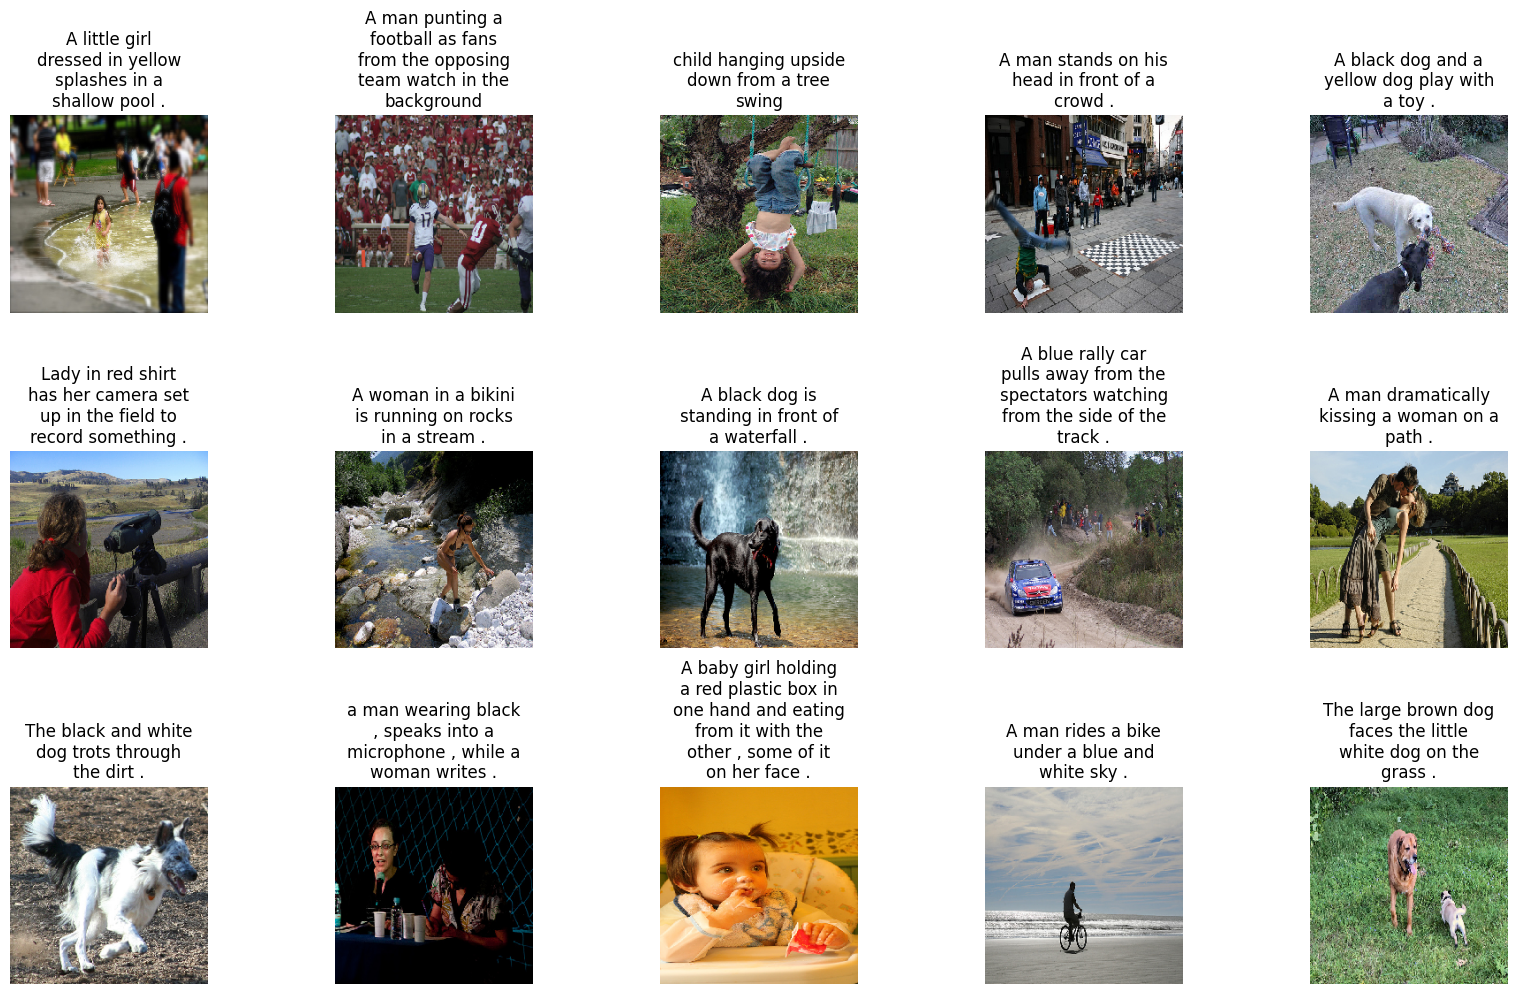

In [ ]:
display_images(data.sample(15))

In [ ]:
with open(os.path.join(CAP_DIR), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 574624.07it/s]


In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1015118661_980735411b']

['A boy smiles in front of a stony wall in a city .',
 'A little boy is standing on the street while a man in overalls is working on a stone wall .',
 'A young boy runs aross the street .',
 'A young child is walking on a stone paved street with a metal pole and a man behind him .',
 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1015118661_980735411b']

['startseq boy smiles in front of stony wall in city endseq',
 'startseq little boy is standing on the street while man in overalls is working on stone wall endseq',
 'startseq young boy runs aross the street endseq',
 'startseq young child is walking on stone paved street with metal pole and man behind him endseq',
 'startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train and Split

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
image_ids = list(mapping.keys())
# Split the data into training, validation, and testing sets
train_val, test = train_test_split(image_ids, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.056, random_state=42)  # 0.056 = 0.05 / (1 - 0.1)

# Verify the lengths of the sets
print("Training set length:", len(train))
print("Validation set length:", len(val))
print("Testing set length:", len(test))

In [ ]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # Process each caption
            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model creation

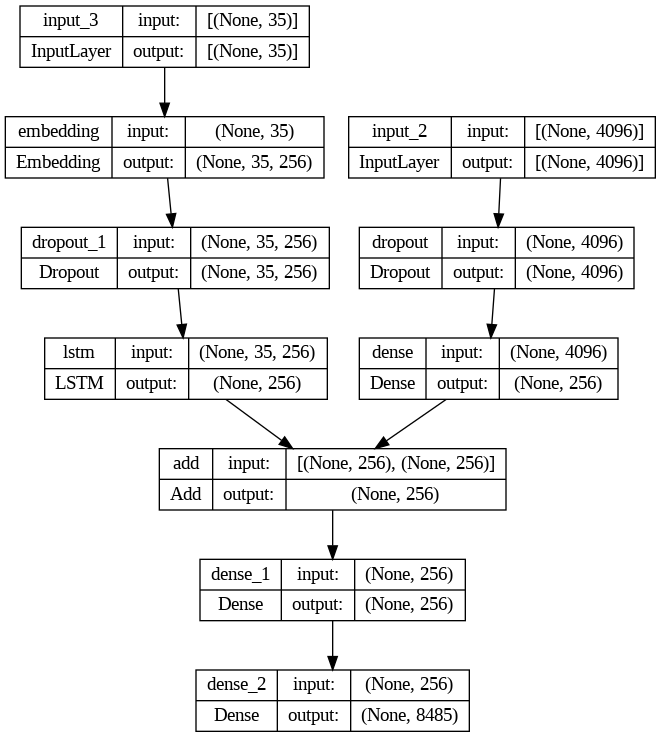

In [ ]:
# Encoder model
# Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

In [ ]:
# Train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size
validation_steps = len(val) // batch_size

history = model.fit(
    data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    epochs=epochs,
    steps_per_epoch=steps,
    validation_data=data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/20
214/214 [==============================] - 88s 383ms/step - loss: 5.2341 - val_loss: 4.4387
Epoch 2/20
214/214 [==============================] - 63s 293ms/step - loss: 4.0275 - val_loss: 3.9965
Epoch 3/20
214/214 [==============================] - 64s 297ms/step - loss: 3.5939 - val_loss: 3.8977
Epoch 4/20
214/214 [==============================] - 63s 296ms/step - loss: 3.3215 - val_loss: 3.8862
Epoch 5/20
214/214 [==============================] - 64s 299ms/step - loss: 3.1235 - val_loss: 3.9055
Epoch 6/20
214/214 [==============================] - 64s 299ms/step - loss: 2.9760 - val_loss: 3.9296
Epoch 7/20
214/214 [==============================] - 62s 291ms/step - loss: 2.8566 - val_loss: 3.9442
Epoch 8/20
214/214 [==============================] - 61s 284ms/step - loss: 2.7610 - val_loss: 3.9569
Epoch 9/20
214/214 [==============================] - 60s 279ms/step - loss: 2.6736 - val_loss: 4.0446
Epoch 10/20
214/214 [==============================] - 59s 276ms/step - l

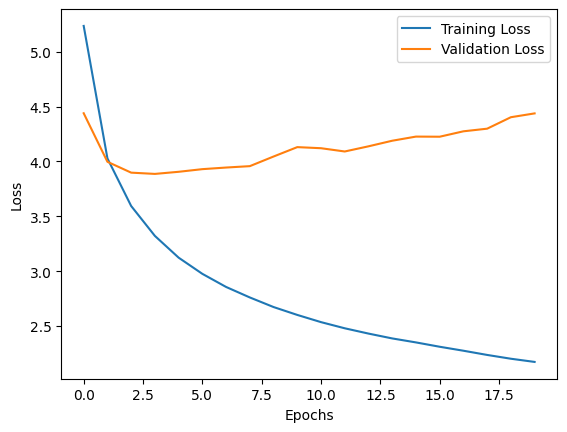

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save(os.path.join('best_model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Caption generation



In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# Generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # Add start tag for generation process
    in_text = 'startseq'
    # Iterate over the max length of sequence
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # Get index with high probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if word not found
        if word is None:
            break
        # Append word as input for generating next word
        in_text += " " + word
        # Stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual caption
    captions = mapping[key]
    # Predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # Append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [09:09<00:00,  1.47it/s]


BLEU-1: 0.552014
BLEU-2: 0.331334


## Visualization of results

In [ ]:
from PIL import Image
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(IMG_DIR, image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq blond dog and black and white dog run in dirt field endseq
startseq dog chases another dog endseq
startseq yellow dog and black and white dog are running in the dirt endseq
startseq two dogs are running in field endseq
startseq two dogs running around endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other on the ground endseq


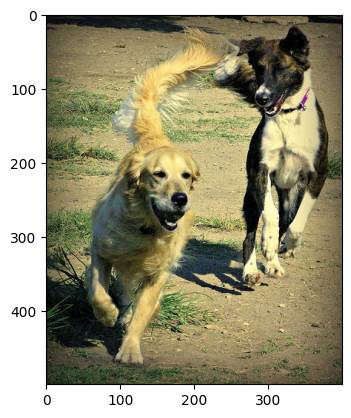

In [ ]:
generate_caption("1095590286_c654f7e5a9.jpg")

---------------------Actual---------------------
startseq boy bites hard into treat while he sits outside endseq
startseq child biting into baked good endseq
startseq small boy putting something in his mouth with both hands endseq
startseq the boy eats his food outside at the table endseq
startseq the boy is eating pizza over tin dish endseq
--------------------Predicted--------------------
startseq man bites baby with his hands endseq


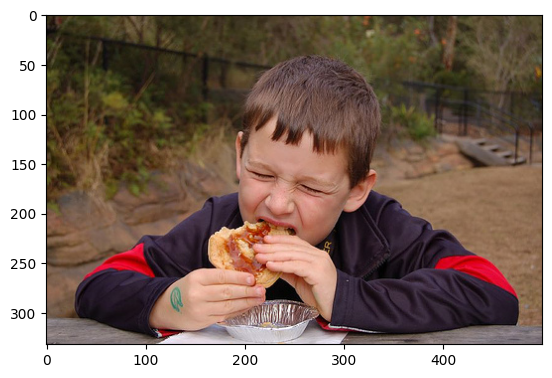

In [ ]:
generate_caption("1034276567_49bb87c51c.jpg")

---------------------Actual---------------------
startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq
--------------------Predicted--------------------
startseq man wears glasses and black hat endseq


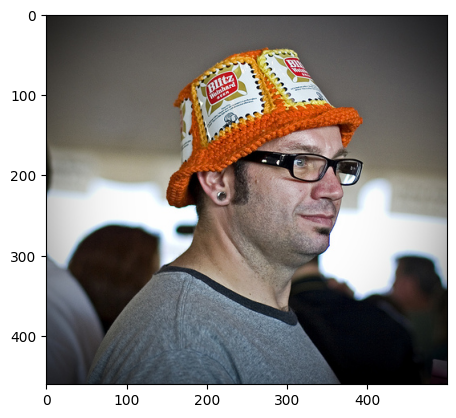

In [ ]:
generate_caption("1007129816_e794419615.jpg")

---------------------Actual---------------------
startseq black dog leaps over log endseq
startseq grey dog is leaping over fallen tree endseq
startseq large black dog leaps fallen log endseq
startseq mottled black and grey dog in blue collar jumping over fallen tree endseq
startseq the black dog jumped the tree stump endseq
--------------------Predicted--------------------
startseq black dog is climbing over log endseq


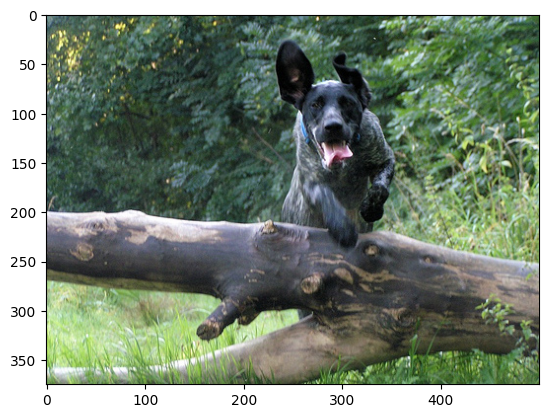

In [ ]:
generate_caption("1015584366_dfcec3c85a.jpg")

---------------------Actual---------------------
startseq two draft horses pull cart through the snow endseq
startseq two golden brown horses pull sleigh driven by woman in blue coat endseq
startseq two horses are pulling woman in cart endseq
startseq two horses pull carriage driven by woman over snow covered ground endseq
startseq two horses pulling sled steered by smiling blond woman endseq
--------------------Predicted--------------------
startseq woman with red and red colored coat rides horse endseq


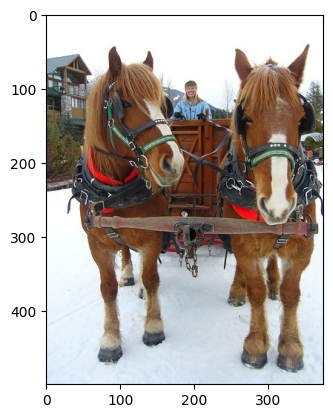

In [ ]:
generate_caption("109202801_c6381eef15.jpg")

---------------------Actual---------------------
startseq bicycle rider is crossing street endseq
startseq bicyclist getting ready to cross street endseq
startseq biker in spandex riding on busy street endseq
startseq man in blue and white biking gear rides down busy street endseq
startseq man wearing helmet riding his bicycle down the street endseq
--------------------Predicted--------------------
startseq man is riding bike bike on city street endseq


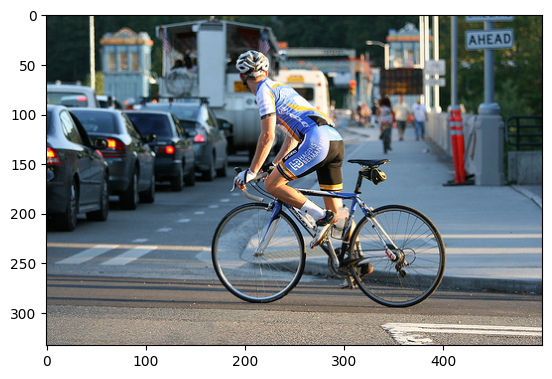

In [ ]:
generate_caption("1143373711_2e90b7b799.jpg")

---------------------Actual---------------------
startseq black and white dog is running in the grass endseq
startseq black dog is running across low cut field nearby an area of trees endseq
startseq black dog runs through field endseq
startseq dog runs in field endseq
startseq large black and white dog is running through grassy field endseq
--------------------Predicted--------------------
startseq black and white dog is running through field endseq


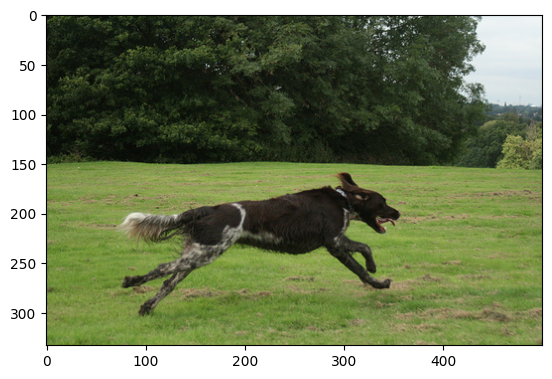

In [ ]:
generate_caption("1330645772_24f831ff8f.jpg")

---------------------Actual---------------------
startseq white dog and black dog in field endseq
startseq white dog with branch in his mouth and black dog endseq
startseq white dog with stick in his mouth standing next to black dog endseq
startseq "two dogs are standing next to each other and the white dog has stick in its mouth ." endseq
startseq two dogs stand in the brown grass endseq
--------------------Predicted--------------------
startseq two dogs playfully wrestle in the grass endseq


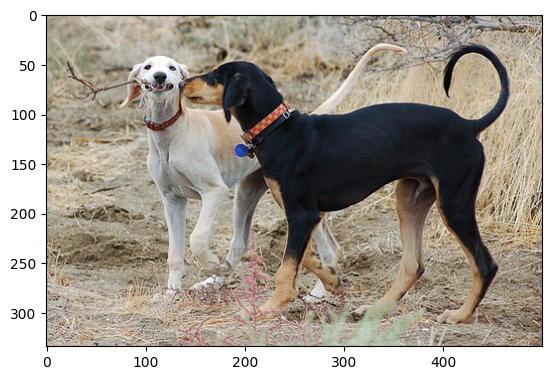

In [ ]:
generate_caption("1429546659_44cb09cbe2.jpg")

---------------------Actual---------------------
startseq brown dog runs for white and black dog on the grass endseq
startseq white dog and brown dog play in the grass endseq
startseq the dogs are in the field playing endseq
startseq two dogs playing on grass endseq
startseq two dogs play together endseq
--------------------Predicted--------------------
startseq dog is running through the grass endseq


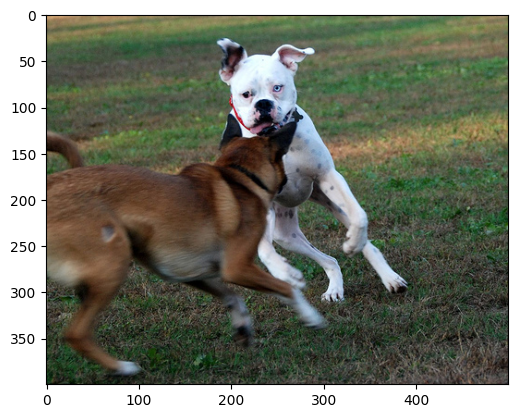

In [ ]:
generate_caption("1778020185_1d44c04dae.jpg")

---------------------Actual---------------------
startseq dog with few leashes and vest on pulls at something with its mouth endseq
startseq dog with harness and toy its mouth endseq
startseq dog with reflective harness looks at the camera endseq
startseq dog with toy in its mouth eyes the camera endseq
startseq small black and white dog in harness is looking at the camera endseq
--------------------Predicted--------------------
startseq dog with harness on its head is shaking off of yellow frisbee endseq


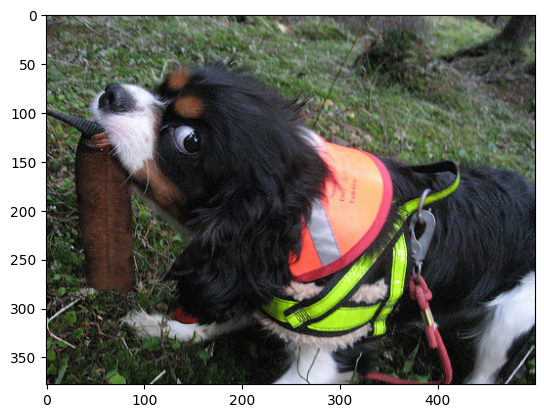

In [ ]:
generate_caption("1827560917_c8d3c5627f.jpg")

---------------------Actual---------------------
startseq blond girl with sunglasses on her head looks squeamish endseq
startseq woman wearing sunglasses endseq
startseq woman wearing sunglasses on her head looking down endseq
startseq woman wearing black shirt and glasses on head reacting to something endseq
startseq woman with black sunglasses looks down at something endseq
--------------------Predicted--------------------
startseq woman with sunglasses on her face is holding onto cellphone endseq


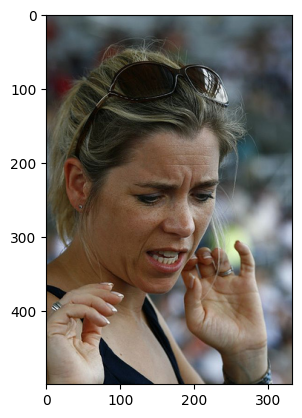

In [ ]:
generate_caption("1989145280_3b54452188.jpg")

---------------------Actual---------------------
startseq "a person in blue jacket wearing bicycle helmet is riding bike" endseq
startseq woman is riding her bicycle endseq
startseq woman riding bike in park endseq
startseq woman with blue jacket wears helmet as she rides bike endseq
startseq woman with helmet riding bike endseq
--------------------Predicted--------------------
startseq man in blue jacket riding bike endseq


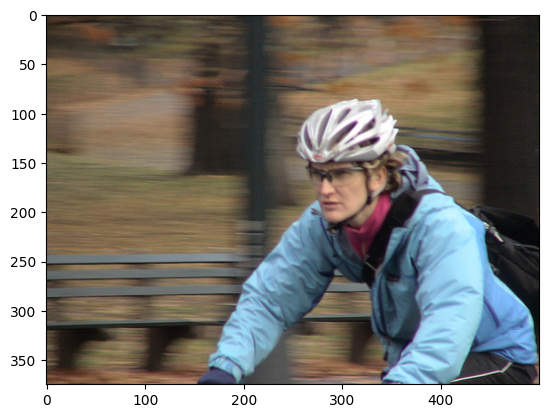

In [ ]:
generate_caption("2084217208_7bd9bc85e5.jpg")

---------------------Actual---------------------
startseq man cleaning the inside of large pane of glass endseq
startseq man holds up blue cloth and smiles endseq
startseq man is holding up plastic jug indoors endseq
startseq man smiles while he washes windows endseq
startseq the man is wearing black shirt and holding up blue item in window endseq
--------------------Predicted--------------------
startseq man in black shirt and black washes windows endseq


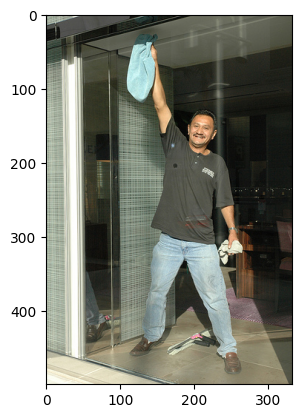

In [ ]:
generate_caption("2045109977_b00ec93491.jpg")